<a href="https://www.kaggle.com/code/nishantgaurav23/market-basket-analysis-apriori-algorithm?scriptVersionId=92360717" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instacart-market-basket-analysis/departments.csv.zip
/kaggle/input/instacart-market-basket-analysis/sample_submission.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv.zip
/kaggle/input/instacart-market-basket-analysis/orders.csv.zip
/kaggle/input/instacart-market-basket-analysis/products.csv.zip
/kaggle/input/instacart-market-basket-analysis/aisles.csv.zip


### Import required packages

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import os
import zipfile
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### **Stage 1:** Data Wrangling

We have five different files:

`
- orders.csv
- order_products_train.csv
- products.csv
- aisles.csv
- departments.csv
`

These files contain the necessary data to solve the problem .Load all the files correctly, after observing the header level details, data records etc

**Hint:** read_csv from pandas

### Load the data
Load all the given datasets

In [3]:
# extract and read files
root = "/kaggle/input/instacart-market-basket-analysis/"
folder = os.listdir(root)
missing_value_formats = ["n.a.","?","NA","n/a", "na", "--","-"]

for file in folder:
    if file.endswith('.zip'):
            with zipfile.ZipFile(root+file, 'r') as zip_ref:
                zip_ref.extractall("kaggle/working/")

data = {}
for file in os.listdir("kaggle/working/"):
    if file.endswith('.csv'):
        data[file[:file.find('.')]] = pd.read_csv("kaggle/working/"+file, na_values = missing_value_formats)
        
data.keys()

dict_keys(['products', 'orders', 'order_products__prior', 'order_products__train', 'departments', 'sample_submission', 'aisles'])

In [4]:
for dirname, _, filenames in os.walk('/kaggle/working/kaggle/working'):
    for filename in filenames:
        if filename.startswith('__'):
            pass
        else:
            print(os.path.join(dirname, filename))
            

/kaggle/working/kaggle/working/products.csv
/kaggle/working/kaggle/working/orders.csv
/kaggle/working/kaggle/working/order_products__prior.csv
/kaggle/working/kaggle/working/order_products__train.csv
/kaggle/working/kaggle/working/departments.csv
/kaggle/working/kaggle/working/sample_submission.csv
/kaggle/working/kaggle/working/aisles.csv
/kaggle/working/kaggle/working/__MACOSX/._order_products__prior.csv
/kaggle/working/kaggle/working/__MACOSX/._departments.csv
/kaggle/working/kaggle/working/__MACOSX/._orders.csv
/kaggle/working/kaggle/working/__MACOSX/._aisles.csv
/kaggle/working/kaggle/working/__MACOSX/._order_products__train.csv
/kaggle/working/kaggle/working/__MACOSX/._products.csv


In [5]:
#root = '/kaggle/input/instacart-market-basket-analysis/'
for file in os.listdir("/kaggle/working/kaggle/working/"):
    
    root1 = "/kaggle/working/kaggle/working/"
    if file == '__MACOSX':
        pass
    elif (file == 'order_products__prior.csv' or file == 'sample_submission.csv'):
        pass
    else:
        orders = pd.read_csv(root1 + 'orders.csv')
        order_products_train = pd.read_csv(root1 + 'order_products__train.csv')
        products = pd.read_csv(root1 + 'products.csv')
        aisles = pd.read_csv(root1 + 'aisles.csv')
        departments = pd.read_csv(root1 + 'departments.csv')

In [6]:
datasets = {}

for i in os.listdir('/kaggle/working/kaggle/working/'):
    if i == '__MACOSX':
        pass
    elif (i == 'order_products__prior.csv' or i == 'sample_submission.csv'):
        pass
    else:
        print(i)
        datasets[i] = pd.read_csv("/kaggle/working/kaggle/working/"+i)
    
datasets = dict(sorted(datasets.items()))
datasets.keys()

products.csv
orders.csv
order_products__train.csv
departments.csv
aisles.csv


dict_keys(['aisles.csv', 'departments.csv', 'order_products__train.csv', 'orders.csv', 'products.csv'])

In [7]:
names = list(datasets.keys())
names

['aisles.csv',
 'departments.csv',
 'order_products__train.csv',
 'orders.csv',
 'products.csv']

### Data Integration

As the required data is present in different files, we need to integrate all the five to make single dataframe/dataset. For that purpose, use the unique identifier provided in all the dataframes so that it can be used to map the data in different files correctly.

**Example:** `product_id` is available in both `products` dataframe and `order_products_train` dataframe, we can merge these two into a single dataframe based on `product_id`

**Hint:** [pd.merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

In [8]:
df1 = datasets[names[2]]
df1.columns, df1.shape

(Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object'),
 (1384617, 4))

In [9]:
df2 = df1.merge(datasets[names[-1]], on='product_id')
df2.columns, df2.shape

(Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
        'product_name', 'aisle_id', 'department_id'],
       dtype='object'),
 (1384617, 7))

In [10]:
df3 = df2.merge(datasets[names[0]], on='aisle_id')
df3.columns, df3.shape

(Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
        'product_name', 'aisle_id', 'department_id', 'aisle'],
       dtype='object'),
 (1384617, 8))

In [11]:
df4 = df3.merge(datasets[names[3]], on='order_id')
df4.columns, df4.shape

(Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
        'product_name', 'aisle_id', 'department_id', 'aisle', 'user_id',
        'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
        'days_since_prior_order'],
       dtype='object'),
 (1384617, 14))

In [12]:
df5 = df4.merge(datasets[names[1]], on='department_id')
df5.columns, df5.shape

(Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
        'product_name', 'aisle_id', 'department_id', 'aisle', 'user_id',
        'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
        'days_since_prior_order', 'department'],
       dtype='object'),
 (1384617, 15))

In [13]:
df5.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,112108,train,4,4,10,9.0,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,112108,train,4,4,10,9.0,dairy eggs
2,1,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,112108,train,4,4,10,9.0,dairy eggs
3,816049,49302,7,1,Bulgarian Yogurt,120,16,yogurt,47901,train,14,4,6,16.0,dairy eggs
4,816049,35176,5,1,Cream Cheese Cream Cheese Spread,108,16,other creams cheeses,47901,train,14,4,6,16.0,dairy eggs


In [14]:
final_df = df5

### Understanding relationship and new insights from the data
1. How many times was each product ordered?
    **Hint:** group orders by product
2. Find the numbers of orders per department and visualize using an appropriate plot.

3. On which day of the week do customers tend to buy more groceries? Which are the peak hours of shopping?

    * Find the frequency of orders on week days  using an appropriate plot
    * Find the frwquency of orders during hours of the day using and appropriate plot?
    
4. Find the ratio of Re-ordered and Not Re-ordered products and visualize it
 
5. Plot the heatmap of Re-order ratio of the Day of week vs Hour of day

### Group orders by products and get how many times each product was ordered

In [15]:
g = final_df.product_id.value_counts()
g = pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["product_id", "count"]
g_products = g.merge(datasets['products.csv'], on="product_id")
g_products.head()

,product_id,count,product_name,aisle_id,department_id
0,24852,18726,Banana,24,4
1,13176,15480,Bag of Organic Bananas,24,4
2,21137,10894,Organic Strawberries,24,4
3,21903,9784,Organic Baby Spinach,123,4
4,47626,8135,Large Lemon,24,4


<Figure size 3600x2880 with 0 Axes>

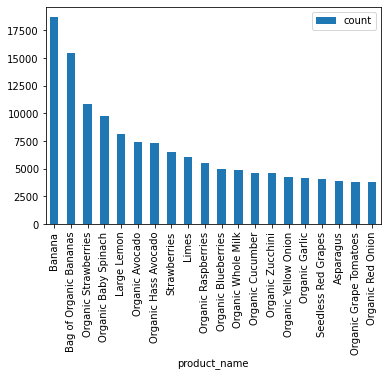

In [16]:
plt.figure(figsize=(50, 40))
g_products.head(20).plot(kind="bar", x="product_name", y="count")
plt.show()

(Banana is top ordered product)

### Find the number of orders per department
Hint: Groupby

In [17]:
g = final_df.department_id.value_counts()
g = pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["department_id", "count"]
g_dept = g.merge(datasets['departments.csv'], on="department_id")
g_dept.head()

,department_id,count,department
0,4,409087,produce
1,16,217051,dairy eggs
2,19,118862,snacks
3,7,114046,beverages
4,1,100426,frozen


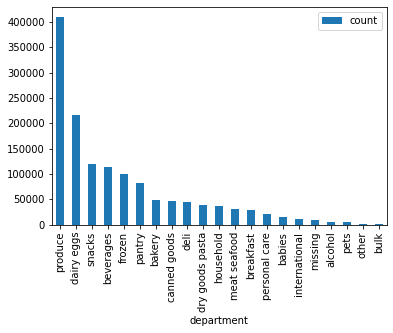

In [18]:
g_dept.plot(kind="bar", x="department", y="count")
plt.show()

### Find the frequency of orders on week days

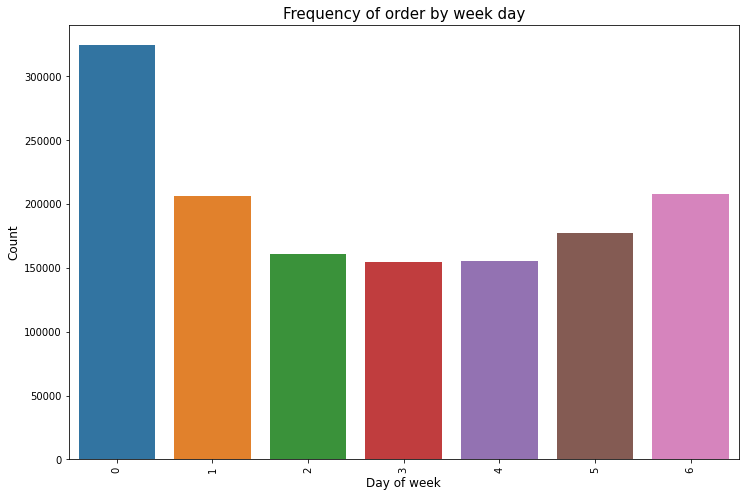

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=final_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

### Find the frequency of orders for hours of the day

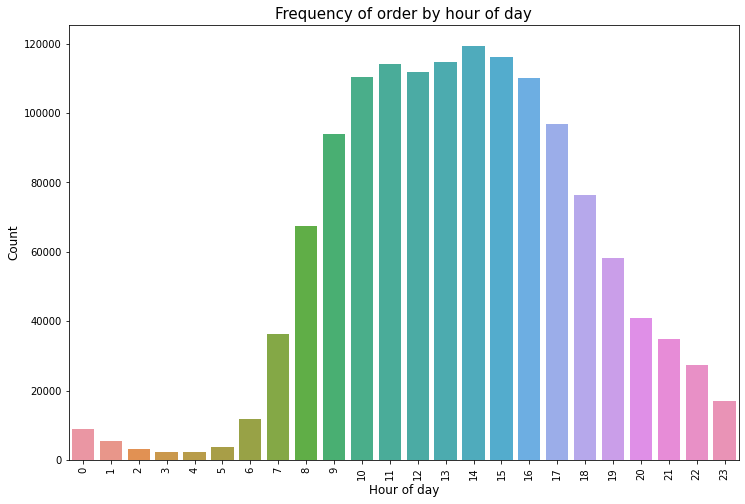

In [20]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=final_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

### Find the ratio of Re-ordered and Not Re-ordered product and visualize

In [21]:
final_df[final_df['reordered'] == 1]['product_id'].max() #nunique()

49688

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


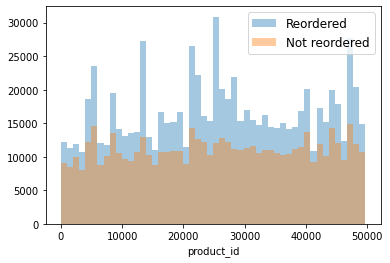

In [22]:
sns.distplot(final_df[final_df['reordered'] == 1]['product_id'], kde=False, label='Reordered')
sns.distplot(final_df[final_df['reordered'] == 0]['product_id'], kde=False, label='Not reordered')

plt.legend(prop={'size': 12})
plt.show()

### Plot the heatmap of Re-ordered ratio of week vs Hour of day?

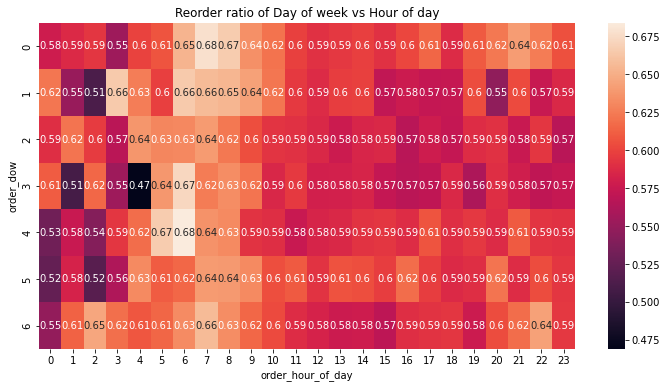

In [23]:
grouped_df = final_df.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12, 6))
sns.heatmap(grouped_df, annot=True)
plt.title("Reorder ratio of Day of week vs Hour of day")
plt.show()

### Stage 2: Create a basket

As the dataset contains huge amout of data, let us take a subset of the data to extract the association rules from it.

**Assumptions:** Segment the data by considering the 100 most frequent ordered items. Please note it is just an assumption. You can consider 'n frequent order items as per your choice.

**Hint:**

* Drop the unwanted columns

* Find the frequencies of orders based on the products and consider 100 most frequent order items

    **Hint:** Count the frequencies of orders for each product_id using `groupby()` and `count()` respectively
    
 * Extract the records of 100 most frequent items(which are extracted in previous step) from combined dataframe.
 
 * Create a Pivot table with `order_id` as index and `product_name` as columns and `reorder` as values.
 
     * set the `order_id` as index using set_index()
     * fill all the nan values with 0
     
  * After performing the above step, tehre are a lot of zeros in the data, make sure that any positive values are converted to a 1 and anything less than 0 is set to 0.

In [24]:
product_counts = final_df.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
product_counts = product_counts.sort_values('frequency', ascending=False)[0:100].reset_index(drop=True)
product_counts.head(10)

,product_id,frequency
0,24852,18726
1,13176,15480
2,21137,10894
3,21903,9784
4,47626,8135
5,47766,7409
6,47209,7293
7,16797,6494
8,26209,6033
9,27966,5546


In [25]:
freq_products = list(product_counts.product_id)
freq_products[1:10]

[13176, 21137, 21903, 47626, 47766, 47209, 16797, 26209, 27966]

In [26]:
order_products = final_df[final_df.product_id.isin(freq_products)]
order_products.shape

(314227, 15)

In [27]:
basket = order_products.pivot_table(columns='product_name', values='reordered', index='order_id').reset_index().fillna(0).set_index('order_id')

In [28]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
basket = basket.applymap(encode_units)
basket.head()

product_name,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Blueberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,...,Sparkling Lemon Water,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### **Stage 3:** Apply Apriori algorithm

* As the dataset contains huge amount of data, let us take a subset of the data to extract the association rules from it.

    **Assumptions:** Segment the basket by considering 100000 record. Please note its just an assumption, you can consider 'n' records as per choice.
    
     **Hint:** [apriori](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/)

- Find the association rules and make a dataframe

In [29]:
shortbasket = basket[:100000]

In [30]:
frequent_items = apriori(shortbasket, min_support=0.01, use_colnames=True)
frequent_items.head()

,support,itemsets
0,0.018668,(100% Whole Wheat Bread)
1,0.013298,(2% Reduced Fat Milk)
2,0.017304,(Apple Honeycrisp Organic)
3,0.026180,(Asparagus)
4,0.142376,(Bag of Organic Bananas)


In [31]:
rules = association_rules(frequent_items, metric='lift', min_threshold=1)
rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
19,(Limes),(Large Lemon),0.045115,0.063111,0.010325,0.228862,3.626315,0.007478,1.214942
18,(Large Lemon),(Limes),0.063111,0.045115,0.010325,0.163600,3.626315,0.007478,1.141661
31,(Organic Strawberries),(Organic Raspberries),0.091668,0.045594,0.013074,0.142625,3.128143,0.008895,1.113172
30,(Organic Raspberries),(Organic Strawberries),0.045594,0.091668,0.013074,0.286749,3.128143,0.008895,1.273511
21,(Organic Avocado),(Large Lemon),0.066340,0.063111,0.010293,0.155156,2.458445,0.006106,1.108948
20,(Large Lemon),(Organic Avocado),0.063111,0.066340,0.010293,0.163093,2.458445,0.006106,1.115608
3,(Bag of Organic Bananas),(Organic Hass Avocado),0.142376,0.064379,0.021449,0.150651,2.340054,0.012283,1.101574
2,(Organic Hass Avocado),(Bag of Organic Bananas),0.064379,0.142376,0.021449,0.333168,2.340054,0.012283,1.286117
4,(Organic Raspberries),(Bag of Organic Bananas),0.045594,0.142376,0.014811,0.324842,2.281578,0.008319,1.270257
5,(Bag of Organic Bananas),(Organic Raspberries),0.142376,0.045594,0.014811,0.104026,2.281578,0.008319,1.065217
